### Ticket 1: Data Preparation & Cleaning

In [334]:
# Load libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import re

In [335]:
# Import dataset

path = r"C:\Users\ntomb\Desktop\Scrappy-20250215T170650Z-001\Scrappy\Scraped_files\Delli_products.csv"
delli_df = pd.read_csv(path)

# Make a copy

df = delli_df.copy()

pd.set_option('display.max_colwidth', None)

In [336]:
# Determine the first 5 itm on the dataframe

df.head()

,name,price,url
0,DELLI 'Start Here' Box,£32.00,/products/delli-start-here-box
1,'Nice And Spice' Box,£32.00,/products/the-nice-and-spice-box
2,Irn Bru & Whisky Hot Sauce,£6.95,/products/irn-bru-whisky-hot-sauce
3,"'Sugar, Spice & All Things Nice' Box",£32.00,/products/sugar-spice-all-things-nice-box
4,Crispy Chicken Skin Sambal,£9.50,/products/mirin-crispy-chicken-skin-sambal


In [337]:
# Change column name 

df.rename(columns={'name':'Name','price':'Price_GBP','url':'Image_Url'}, inplace=True)

# concat https://delli.market/ to image url
df["Image_Url"] = "https://delli.market" + df["Image_Url"]
df.head(2)

,Name,Price_GBP,Image_Url
0,DELLI 'Start Here' Box,£32.00,https://delli.market/products/delli-start-here-box
1,'Nice And Spice' Box,£32.00,https://delli.market/products/the-nice-and-spice-box


In [338]:
# Clean trailing whitespace and qoutes

df['Name'] = df['Name'].str.replace('[\'"]', '', regex=True).str.strip()



In [339]:
# Remove £ on price and trailing whitespace

df['Price_GBP'] = df['Price_GBP'].replace('£', '', regex=True).str.strip()

# Convert price to nemeric for data analysis

df['Price_GBP'] = pd.to_numeric(df['Price_GBP'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       610 non-null    object 
 1   Price_GBP  443 non-null    float64
 2   Image_Url  610 non-null    object 
dtypes: float64(1), object(2)
memory usage: 14.4+ KB


In [340]:
#  Determine Data type

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       610 non-null    object 
 1   Price_GBP  443 non-null    float64
 2   Image_Url  610 non-null    object 
dtypes: float64(1), object(2)
memory usage: 14.4+ KB


In [341]:
# Determine if there are NaN values
df.isna().sum()

Name           0
Price_GBP    167
Image_Url      0
dtype: int64

In [342]:
# Fill NaN values with 0

df['Price_GBP'] =  df['Price_GBP'].fillna(0)

# confirm the results
df.isna().sum()


Name         0
Price_GBP    0
Image_Url    0
dtype: int64

In [343]:
# Check for duplicate column (There are 3 columns)
# This check is deemed not necessary for columns that are are easily identifiable

df.T.duplicated().any()

False

In [344]:
# Check for duplicate rows

df.duplicated().any()

True

In [345]:
# Find the number duplicated rows

df.duplicated().sum()

59

In [346]:
# Display duplicated rows for name & price

df.loc[df.duplicated(keep=False), ['Name','Price_GBP']]

,Name,Price_GBP
0,DELLI Start Here Box,32.00
1,Nice And Spice Box,32.00
2,Irn Bru & Whisky Hot Sauce,6.95
4,Crispy Chicken Skin Sambal,9.50
6,Chilli Vinegar Dressing,7.80
...,...,...
570,When The Fish Came To Shore (Greek Cookbook) *Soft Cover*,25.00
573,Uno Mag Tomatoes (Cookbook-Magazine),18.00
592,Uno Mag Tomatoes (Cookbook-Magazine),18.00
595,When The Fish Came To Shore (Greek Cookbook) *Soft Cover*,25.00


In [347]:

# Remove duplicated rows

def remove_duplicated_rows(df):
    duplicated_rows = df.drop_duplicates(subset=['Name'], keep='first')
    return duplicated_rows

df = remove_duplicated_rows(df)

# Check duplicated rows if still exist

df.duplicated().any()

False

### Ticket 2: Product Performance Analysis

####  1. Statistics & Analysis:

In [348]:
# convert price from UK pound to ZAR using API 

def update_currency_rates():
    url = "https://api.freecurrencyapi.com/v1/latest"
    params = {
        "apikey": "api key obtained from https://app.freecurrencyapi.com/",
        "base_currency": "GBP",
        "currencies": "ZAR"
    }
    
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        exchange_rate = data['data']['ZAR']
        return exchange_rate
    else:
        print(f"Error fetching exchange rate: {response.status_code}")
        return None

def update_prices(df):
    exchange_rate = update_currency_rates()
    
    if exchange_rate is not None:
        df['Price_ZAR'] = (df['Price_GBP'] * exchange_rate).round(2)
        print(f"Updated exchange rate: 1 GBP = {exchange_rate} ZAR")
    else:
        print("Failed to update prices. Using last known exchange rate.")
    
    return df

df = update_prices(df)

Updated exchange rate: 1 GBP = 23.2480646795 ZAR


In [349]:
# Determine the price ratio of Price_ZAR to Price_GBP

df['Price_ratio'] = (df['Price_ZAR'] / df['Price_GBP']).round(2)

In [350]:
df.describe().round(2)

,Price_GBP,Price_ZAR,Price_ratio
count,548.00,548.00,398.00
mean,8.84,205.61,23.25
std,10.06,233.91,0.00
min,0.00,0.00,23.25
25%,0.00,0.00,23.25
50%,6.20,144.14,23.25
75%,10.00,232.48,23.25
max,60.00,1394.88,23.25


In [351]:
# Determine the most expensive product

Expensive_product = df.loc[df['Price_GBP'].idxmax(), ['Name','Price_GBP']]
Expensive_product

Name         Sober Curious Warmers Box
Price_GBP                         60.0
Name: 472, dtype: object

In [352]:
# Filter for prices above 0; thereafter find the minimum price thereafter

filtered_price = df[df['Price_GBP'] > 0]  

# Determine the least expensive product

cheap_product = filtered_price.loc[filtered_price['Price_GBP'].idxmin(), ['Name', 'Price_GBP']]
cheap_product

Name         Snacking Pickles
Price_GBP                 1.6
Name: 8, dtype: object

In [353]:
# Determine product price by category

filtered_df = df[df['Price_GBP'] > 0]

median_price = filtered_df['Price_GBP'].median()
upper_quartile = filtered_df['Price_GBP'].quantile(0.75)

def categorize_price(price):
    if price <= 0:  
        return 'Invalid'
    elif price < median_price:
        return 'Ordinary'
    elif price < upper_quartile:
        return 'High'
    else:
        return 'Exclusive'

df['Category'] = df['Price_GBP'].apply(categorize_price)


In [354]:
# Determine total items per category & total revenue

Category_analysis = df.groupby('Category').agg(
    total_items=('Price_GBP', 'count'),
    total_revenue_GBP=('Price_GBP', 'sum'),
    total_revenue_ZAR = ('Price_ZAR','sum')
)
Category_analysis

,total_items,total_revenue_GBP,total_revenue_ZAR
Category,,,
Exclusive,100,2697.34,62707.85
High,107,1075.99,25014.57
Invalid,150,0.00,0.00
Ordinary,191,1073.34,24953.10


In [355]:
# Determine Total revenue

Total_revenue = df['Price_GBP'].sum()
Total_revenue 

4846.67

In [356]:
# Summary of a clean data & new columns added
df.head()

,Name,Price_GBP,Image_Url,Price_ZAR,Price_ratio,Category
0,DELLI Start Here Box,32.00,https://delli.market/products/delli-start-here-box,743.94,23.25,Exclusive
1,Nice And Spice Box,32.00,https://delli.market/products/the-nice-and-spice-box,743.94,23.25,Exclusive
2,Irn Bru & Whisky Hot Sauce,6.95,https://delli.market/products/irn-bru-whisky-hot-sauce,161.57,23.25,Ordinary
3,"Sugar, Spice & All Things Nice Box",32.00,https://delli.market/products/sugar-spice-all-things-nice-box,743.94,23.25,Exclusive
4,Crispy Chicken Skin Sambal,9.50,https://delli.market/products/mirin-crispy-chicken-skin-sambal,220.86,23.25,High


In [357]:
# summary of clean rows & columns

df.shape

(548, 6)

#### 2. Visualizations:

In [358]:
sns.set_style('dark')

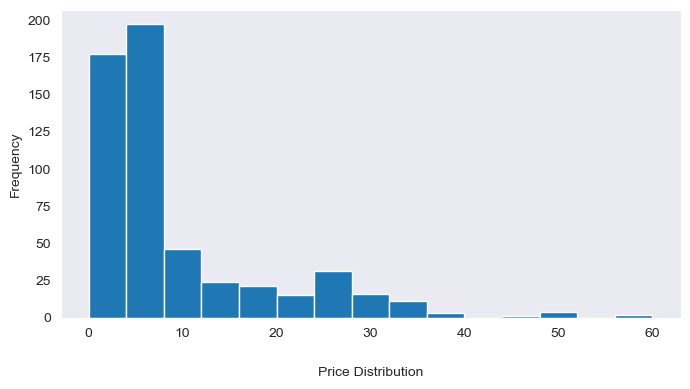

In [359]:
# Determine price distribution

price_counts = df['Price_GBP']

plt.figure(figsize=(8,4))
price_counts.plot(kind='hist',bins=15)
plt.xlabel('Price Distribution')
plt.xlabel('Price Distribution', labelpad=20)
plt.show()


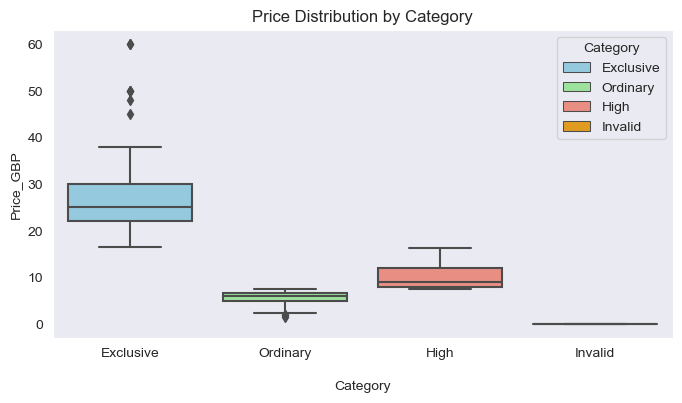

In [360]:
# Determine price distribution by category

plt.figure(figsize=(8,4)) 
 
sns.boxplot( 
    data=df, 
    x='Category', 
    y='Price_GBP', 
    hue='Category',           
    palette=['skyblue','lightgreen','salmon','orange'],   
    dodge=False, 
    
) 
 
plt.title('Price Distribution by Category') 
plt.xlabel('Category', labelpad=15)  
plt.ylabel('Price_GBP') 
plt.show()

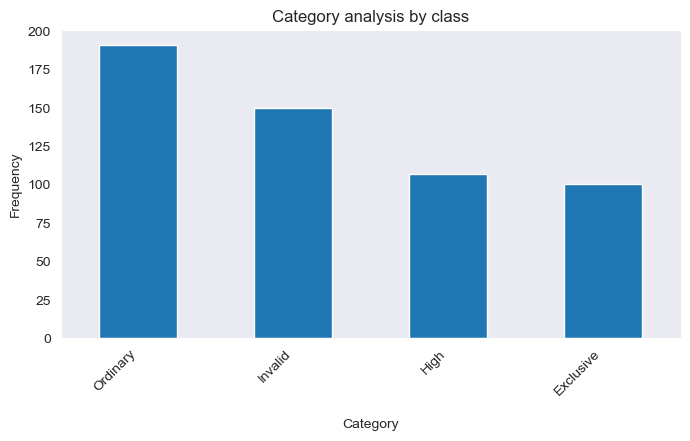

In [361]:
# Category analysis by class

category = df['Category'].value_counts()

plt.figure(figsize=(8,4))
category.plot(kind='bar')
plt.title('Category analysis by class')
plt.ylabel('Frequency')
plt.xlabel('Category')
plt.xlabel('Category', labelpad=15)
plt.xticks(rotation=45,ha='right')
plt.show()

In [362]:
# Revenue analysis by category

revenue_category = df.groupby('Category')['Price_GBP'].sum().reset_index()
revenue_category 

,Category,Price_GBP
0,Exclusive,2697.34
1,High,1075.99
2,Invalid,0.00
3,Ordinary,1073.34


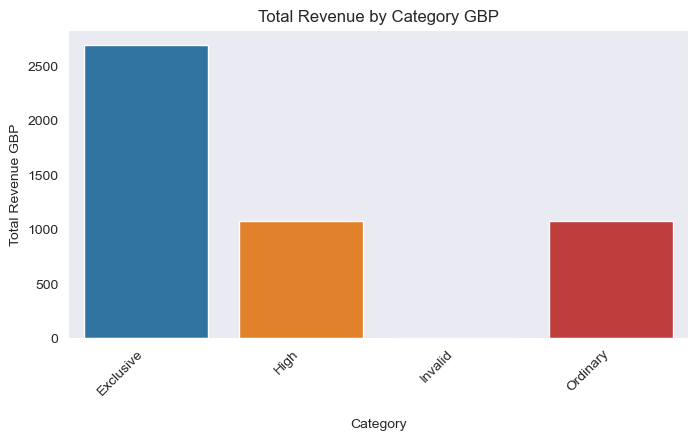

In [363]:
# Category analysis by Revenue

plt.figure(figsize=(8,4))
sns.barplot(data=revenue_category, x='Category', y='Price_GBP')
plt.title('Total Revenue by Category GBP')
plt.xlabel('Category')
plt.xlabel('Category', labelpad=15)
plt.xticks(rotation=45,ha='right')
plt.ylabel('Total Revenue GBP')
plt.show()

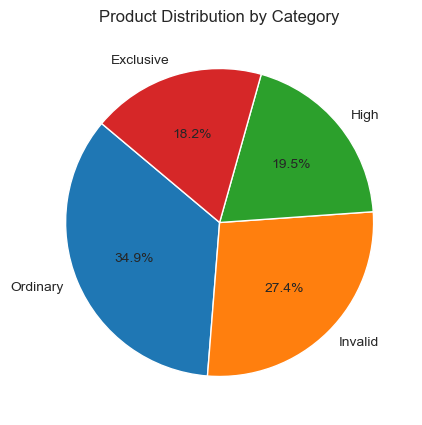

In [364]:
# Determine category disribution by percentage

category_counts = df['Category'].value_counts()

plt.figure(figsize=(6,5))
plt.pie(x=category_counts.values, labels=category_counts.index, 
        autopct='%1.1f%%', startangle=140)
plt.title('Product Distribution by Category')
plt.show()

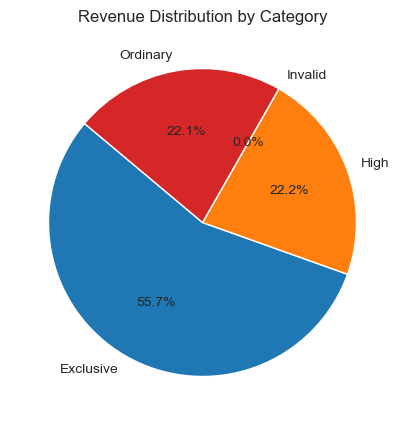

In [365]:
# Determine category revenue by percentage

revenue_category = df.groupby('Category')['Price_GBP'].sum().reset_index()

plt.figure(figsize=(6,5))
plt.pie(x=revenue_category['Price_GBP'], labels=revenue_category['Category'],
        autopct='%1.1f%%', startangle=140)
plt.title('Revenue Distribution by Category')
        
plt.show()